In [1]:
import argparse
import os

os.chdir("..")
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

import math
import yaml
import logging
import random
import numpy as np
import sys
import imageio
from train.trainUtils import *
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn.functional as F


print(torch.cuda.device_count())  # Should be 1
print(torch.cuda.get_device_name(0))  # Should be GPU 1's name

1
NVIDIA RTX A6000


In [2]:
def parse_args(arg_list=None):
    parser = argparse.ArgumentParser(
        description="Unconditioned Video Diffusion Inference"
    )
    parser.add_argument(
        "--dataset-path", type=str, required=True,
        help="Directory containing input reference videos."
    )
    parser.add_argument(
        "--pretrained-model-name-or-path", type=str, required=True,
        help="Path or HF ID where transformer/vae/scheduler are stored."
    )
    parser.add_argument(
        "--checkpoint-path", type=str, required=True,
        help="Path to fine‐tuned checkpoint containing transformer state_dict."
    )
    parser.add_argument(
        "--output-dir", type=str, required=True,
        help="Where to write generated videos."
    )
    parser.add_argument(
        "--model-config", type=str, required=True,
        help="YAML file describing model params (height, width, num_reference, num_target, etc.)"
    )
    parser.add_argument(
        "--batch-size", type=int, default=1,
        help="Batch size per device (usually 1 for inference)."
    )
    parser.add_argument(
        "--num-inference-steps", type=int, default=50,
        help="Number of reverse diffusion steps to run."
    )
    parser.add_argument(
        "--mixed-precision", type=str, default="bf16",
        help="Whether to run backbone in 'fp16', 'bf16', or 'fp32'."
    )
    parser.add_argument(
        "--seed", type=int, default=42,
        help="Random seed for reproducibility."
    )
    parser.add_argument(
        "--shuffle", type=int, default=False,
        help="Whether to shuffle dataset. Usually False for inference."
    )
    parser.add_argument(
        "--is-uncond", type=bool, default=False,
        help=""
    )
    parser.add_argument(
        "--learning-rate", type=float, default=1e-4
    )

    # If arg_list is None, argparse picks up sys.argv; 
    # otherwise it treats arg_list as the full argv list.
    return parser.parse_args(arg_list)

args = [
    "--dataset-path", "/scratch/ondemand28/harryscz/head_audio/data/data256/uv",
    "--pretrained-model-name-or-path", "/scratch/ondemand28/harryscz/model/CogVideoX-2b",
    "--checkpoint-path",  "/scratch/ondemand28/harryscz/head_audio/trainOutput/checkpoint-1000.pt",
    "--output-dir",  "/scratch/ondemand28/harryscz/diffusion/videoOut",
    "--model-config",  "/scratch/ondemand28/harryscz/diffusion/train/model_config.yaml",
    "--batch-size",  "1",
    "--num-inference-steps",  "50",
    "--mixed-precision",  "no",
    "--seed",  "42",
    "--shuffle",  "0",
    "--learning-rate", "0.0001"
]

args = parse_args(args)

with open(args.model_config, "r") as f: model_config = yaml.safe_load(f)


In [3]:
from accelerate import Accelerator
from accelerate.utils import DistributedDataParallelKwargs, ProjectConfiguration, set_seed
from accelerate.logging import get_logger

with open(args.model_config, "r") as f: model_config = yaml.safe_load(f)
if args.mixed_precision.lower() == "fp16":
    dtype = torch.float16
elif args.mixed_precision.lower() == "bf16":
    dtype = torch.bfloat16
else:
    dtype = torch.float32

accelerator_project_config = ProjectConfiguration(project_dir=args.output_dir,
                                                    logging_dir=os.path.join(args.output_dir, "logs"))
ddp_kwargs = DistributedDataParallelKwargs(find_unused_parameters=False)
accelerator = Accelerator(mixed_precision=args.mixed_precision,
                            project_config=accelerator_project_config,
                            kwargs_handlers=[ddp_kwargs])

# 2.4 Set random seed
if args.seed is not None:
    set_seed(args.seed + accelerator.process_index)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

logger = get_logger(__name__)
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger.info("Accelerator state:", accelerator.state)

--- Logging error ---
Traceback (most recent call last):
  File "/scratch/ondemand28/harryscz/anaconda3/envs/pytorch3d/lib/python3.9/logging/__init__.py", line 1083, in emit
    msg = self.format(record)
  File "/scratch/ondemand28/harryscz/anaconda3/envs/pytorch3d/lib/python3.9/logging/__init__.py", line 927, in format
    return fmt.format(record)
  File "/scratch/ondemand28/harryscz/anaconda3/envs/pytorch3d/lib/python3.9/logging/__init__.py", line 663, in format
    record.message = record.getMessage()
  File "/scratch/ondemand28/harryscz/anaconda3/envs/pytorch3d/lib/python3.9/logging/__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/scratch/ondemand28/harryscz/anaconda3/envs/pytorch3d/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/scratch/ondemand28/harryscz/anaconda3/envs/pytorch3d/lib/python3.9/runpy.py", line 87, in

In [4]:
#### Dataset #####
# Video data have shape [B, C, F, H, W]

from data.VideoDataset import VideoDataset 
from torch.utils.data import DataLoader, DistributedSampler

dataset = VideoDataset(
    videos_dir=args.dataset_path,
)
if args.shuffle:
    sampler = DistributedSampler(
        dataset,
        num_replicas=accelerator.num_processes,
        rank=accelerator.process_index,
        shuffle=True
    )
else:
    sampler = None
data_loader = DataLoader(
    dataset,
    batch_size=args.batch_size,
    # sampler=sampler,
    collate_fn=lambda x: x[0],   # since dataset returns already‐batched items
    num_workers=2,
    pin_memory=True,
)
logger.info(f"Number of test examples: {len(data_loader)}")

06/25/2025 17:23:24 - INFO - __main__ - Number of test examples: 13626


In [5]:
#### Load Model ####
device = "cuda:7"
weight_dtype = torch.float32

%load_ext autoreload
%autoreload 2

from diffusers import AutoencoderKLCogVideoX, CogVideoXDDIMScheduler
from model.cap_transformer import CAPVideoXTransformer3DModel
from diffusers.optimization import get_scheduler
from inference.inference_pipeline import *

transformer = CAPVideoXTransformer3DModel.from_pretrained(
    args.pretrained_model_name_or_path,
    low_cpu_mem_usage=False,
    device_map=None,
    ignore_mismatched_sizes=True,
    subfolder="transformer",
    torch_dtype=torch.float32,
    cond_in_channels=1,  # only one channel (the ref_mask)
    sample_width=model_config["width"] // 8,
    sample_height=model_config["height"] // 8,
    sample_frames=50,
    max_text_seq_length=1,
    max_n_references=model_config["max_n_references"],
    apply_attention_scaling=model_config["use_growth_scaling"],
    use_rotary_positional_embeddings=False,
)

vae = AutoencoderKLCogVideoX.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="vae"
)
scheduler = CogVideoXDDIMScheduler.from_pretrained(
    args.pretrained_model_name_or_path,
    subfolder="scheduler",
)

# if args.enable_slicing: vae.enable_slicing()
# if args.enable_tiling:  vae.enable_tiling()

vae.eval().to(dtype)
transformer.eval().to(dtype)

vae, transformer, scheduler, data_loader = accelerator.prepare(vae, transformer, scheduler, data_loader)

Some weights of the model checkpoint at /scratch/ondemand28/harryscz/model/CogVideoX-2b were not used when initializing CAPVideoXTransformer3DModel: 
 ['patch_embed.text_proj.bias, patch_embed.text_proj.weight']
Some weights of CAPVideoXTransformer3DModel were not initialized from the model checkpoint at /scratch/ondemand28/harryscz/model/CogVideoX-2b and are newly initialized: ['patch_embed.cond_proj.bias', 'patch_embed.ref_temp_proj.bias', 'patch_embed.audio_proj.bias', 'patch_embed.audio_proj.weight', 'patch_embed.ref_temp_proj.weight', 'patch_embed.cond_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
trainable_parameters =  list(filter(lambda p: p.requires_grad, transformer.parameters()))
params_to_optimize = [{"params": trainable_parameters, "lr": args.learning_rate}]

optimizer = get_optimizer(
    learning_rate=args.learning_rate,
    adam_beta1=0.9, 
    adam_beta2=0.95, 
    adam_epsilon=1e-8, 
    adam_weight_decay=1e-4, 
    params_to_optimize=params_to_optimize, 
    # use_deepspeed=use_deepspeed_optimizer
)

def encode_video(vae, video):
    with torch.no_grad():
        dist = vae.encode(video).latent_dist.sample()
    latent = dist * vae.config.scaling_factor
    return latent.permute(0,2,1,3,4).contiguous()

def unwrap_model(m):
    m = accelerator.unwrap_model(m)
    return m._orig_mod if hasattr(m, "_orig_mod") else m

def decode_video(vae, latents):
    with torch.no_grad():
        latents = latents.permute(0, 2, 1, 3, 4)  # [batch_size, num_channels, num_frames, height, width]
        latents = 1 / vae.config.scaling_factor * latents

        frames = vae.decode(latents).sample
        return frames
        

In [7]:
import torch
import matplotlib.pyplot as plt

def plot(tensor):
    video_tensor = tensor  # shape: [1, 13, 16, 32, 32]

    # Select a specific frame, e.g., frame 5
    t = 5
    frame = video_tensor[0, t]  # shape: [16, 32, 32]

    # Plot each of the 16 channels
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    axes = axes.flatten()

    for i in range(16):
        channel = frame[i].cpu().numpy()
        axes[i].imshow(channel, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Channel {i}")

    plt.tight_layout()
    plt.show()

def plot_video(tensor):
    video_tensor = tensor  # Replace this with your actual tensor

    # Remove batch dimension: [3, 50, 256, 256]
    video_tensor = video_tensor.squeeze(0)

    # Convert to [T, C, H, W]
    video_tensor = video_tensor.permute(1, 0, 2, 3)  # [50, 3, 256, 256]

    # Convert to numpy for plotting
    frames = video_tensor.cpu().numpy()

    # Normalize (if in range [0, 1], skip this)
    frames = (frames * 255).clip(0, 255).astype("uint8")

    # Plot a few frames
    num_to_plot = 6
    fig, axes = plt.subplots(1, num_to_plot, figsize=(15, 3))

    for i in range(num_to_plot):
        axes[i].imshow(frames[i].transpose(1, 2, 0))  # [H, W, C]
        axes[i].axis("off")
        axes[i].set_title(f"Frame {i}")

    plt.tight_layout()
    plt.show()


  0%|          | 0/13626 [00:00<?, ?it/s]

torch.Size([1, 13, 16, 32, 32])
model_output tensor(-4.1764, device='cuda:0', grad_fn=<MinBackward1>) tensor(4.7599, device='cuda:0', grad_fn=<MaxBackward1>)
Ground Truth t=tensor([804], device='cuda:0'), step=0


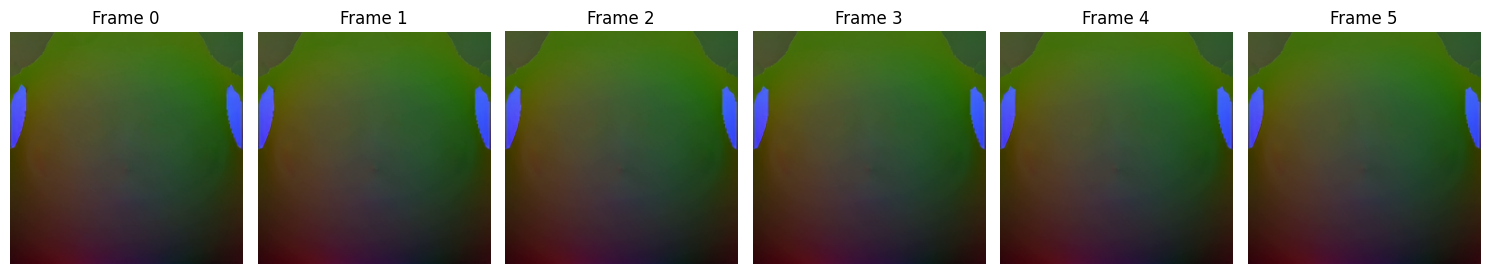

Model Pred t=tensor([804], device='cuda:0'), step=0


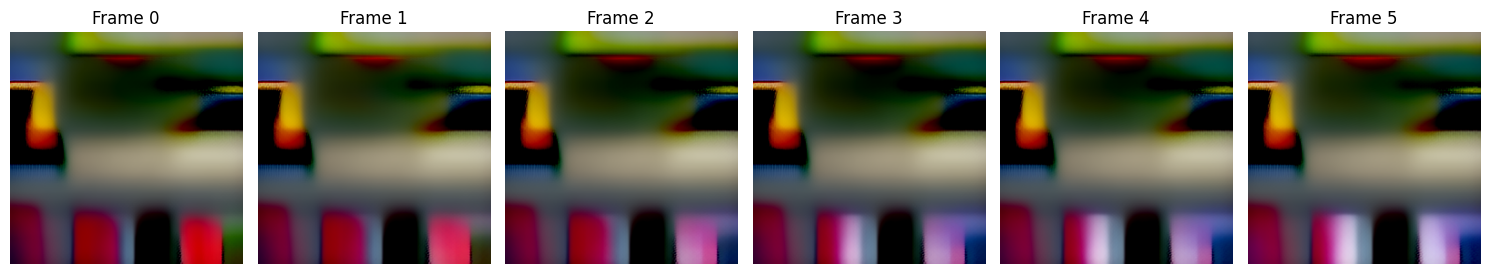

  0%|          | 1/13626 [00:10<40:05:15, 10.59s/it]

0.32533153891563416
torch.Size([1, 13, 16, 32, 32])
model_output tensor(-3.6961, device='cuda:0', grad_fn=<MinBackward1>) tensor(3.8368, device='cuda:0', grad_fn=<MaxBackward1>)
Ground Truth t=tensor([953], device='cuda:0'), step=0


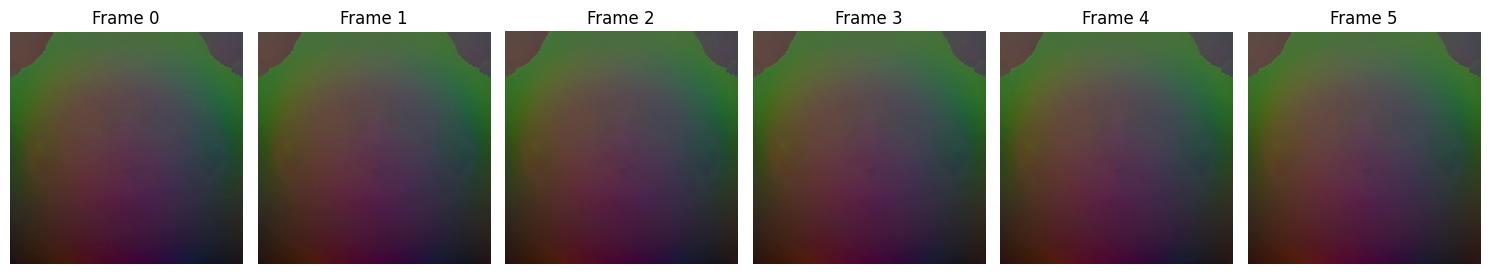

Model Pred t=tensor([953], device='cuda:0'), step=0


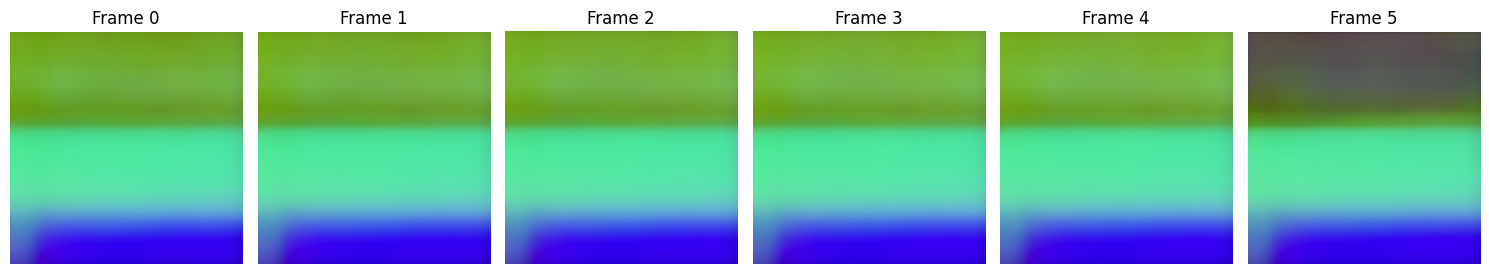

  0%|          | 2/13626 [00:20<38:28:12, 10.17s/it]

0.6525864601135254
torch.Size([1, 13, 16, 32, 32])
model_output tensor(-3.2120, device='cuda:0', grad_fn=<MinBackward1>) tensor(4.0895, device='cuda:0', grad_fn=<MaxBackward1>)
Ground Truth t=tensor([852], device='cuda:0'), step=0


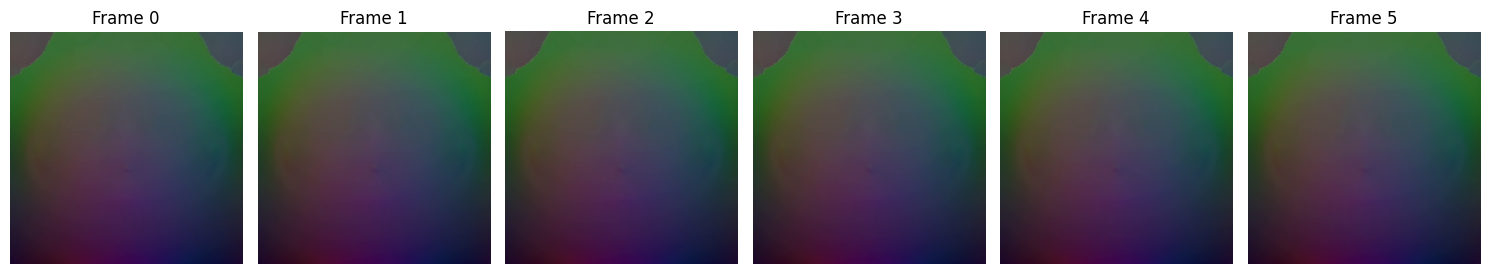

Model Pred t=tensor([852], device='cuda:0'), step=0


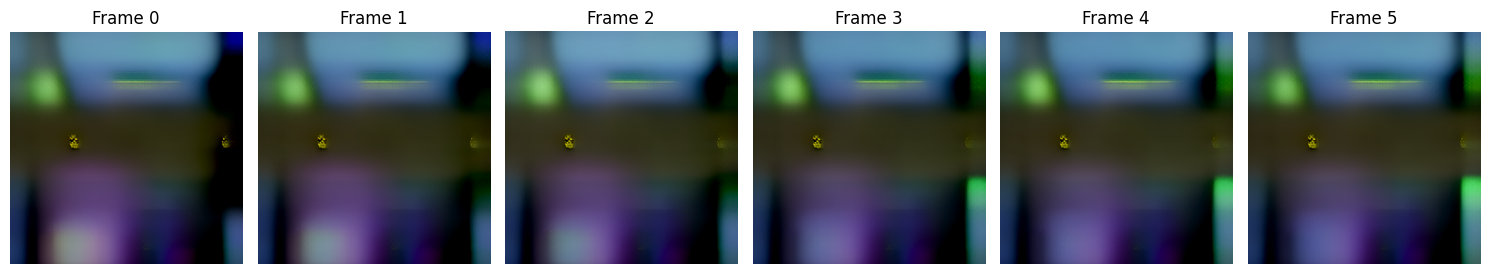

  0%|          | 3/13626 [00:30<37:56:42, 10.03s/it]

0.26666831970214844
torch.Size([1, 13, 16, 32, 32])
model_output tensor(-2.9330, device='cuda:0', grad_fn=<MinBackward1>) tensor(3.4243, device='cuda:0', grad_fn=<MaxBackward1>)
Ground Truth t=tensor([526], device='cuda:0'), step=0


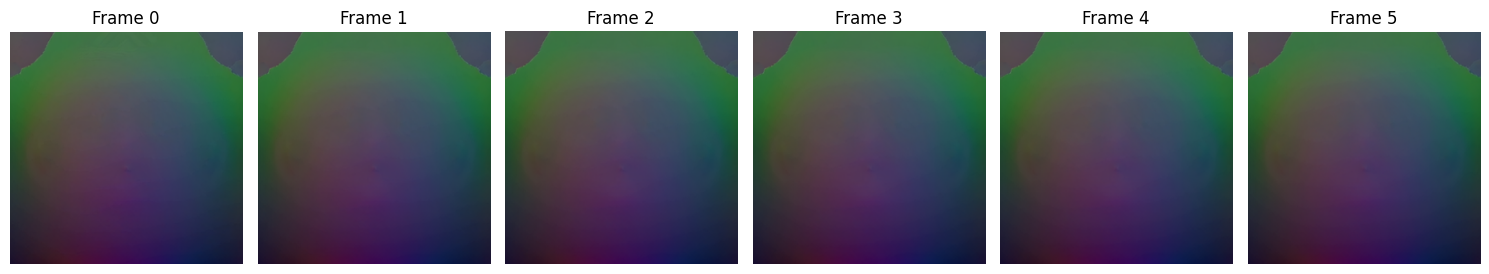

Model Pred t=tensor([526], device='cuda:0'), step=0


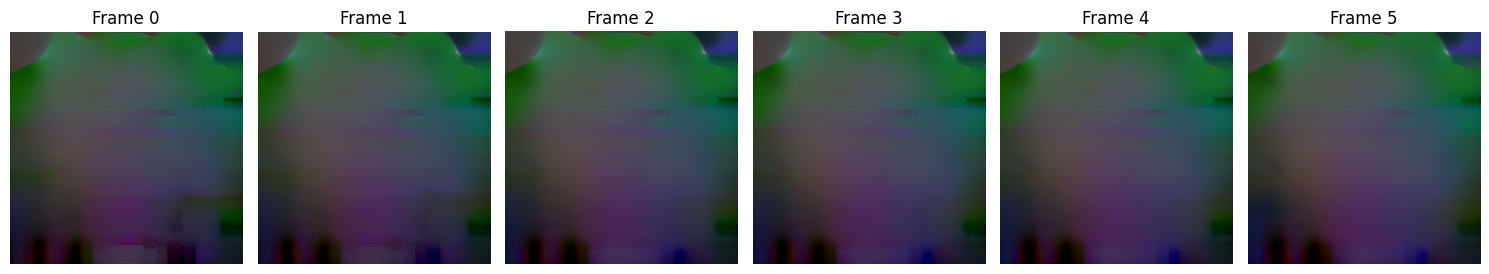

  0%|          | 4/13626 [00:40<37:40:16,  9.96s/it]

0.14197753369808197
torch.Size([1, 13, 16, 32, 32])
model_output tensor(-3.7765, device='cuda:0', grad_fn=<MinBackward1>) tensor(4.5333, device='cuda:0', grad_fn=<MaxBackward1>)
Ground Truth t=tensor([910], device='cuda:0'), step=0


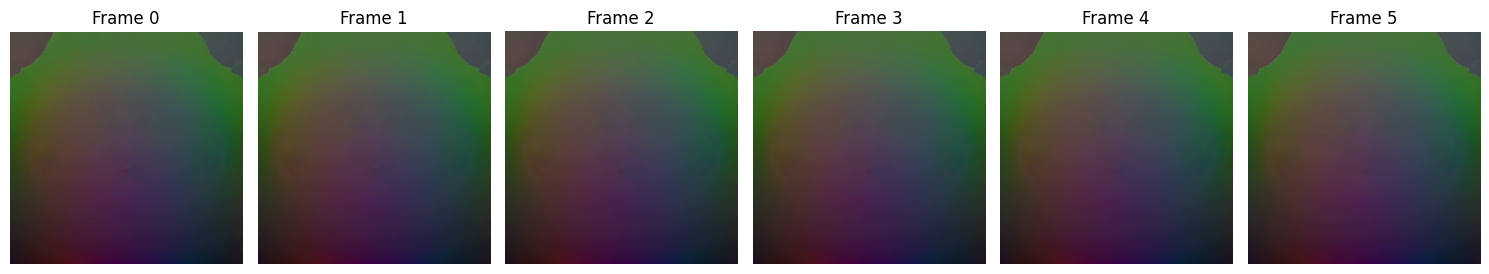

Model Pred t=tensor([910], device='cuda:0'), step=0


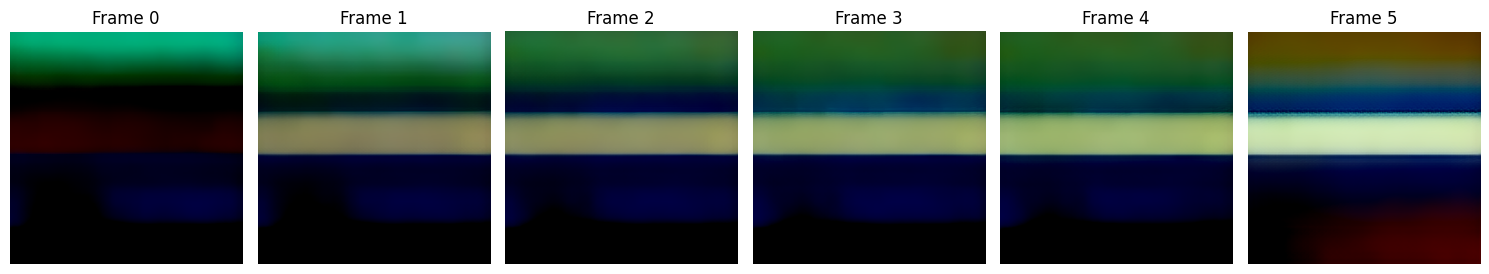

  0%|          | 5/13626 [00:50<38:05:24, 10.07s/it]

0.515406608581543
torch.Size([1, 13, 16, 32, 32])
model_output tensor(-3.3178, device='cuda:0', grad_fn=<MinBackward1>) tensor(3.4017, device='cuda:0', grad_fn=<MaxBackward1>)
Ground Truth t=tensor([362], device='cuda:0'), step=0


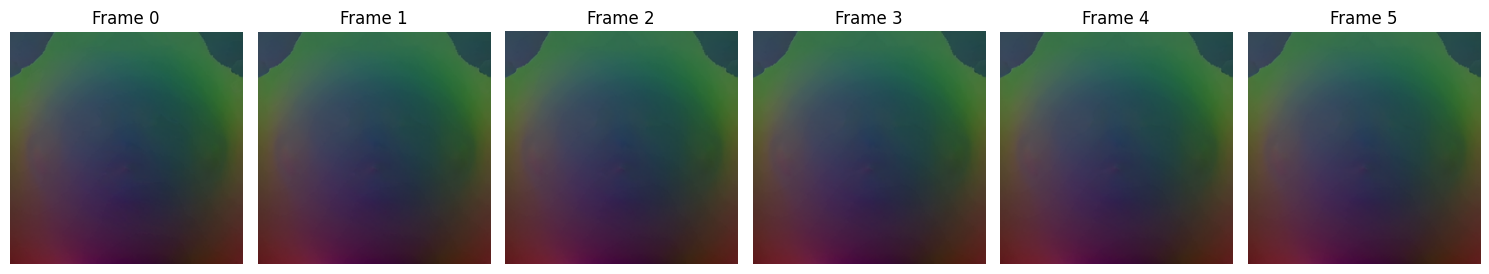

Model Pred t=tensor([362], device='cuda:0'), step=0


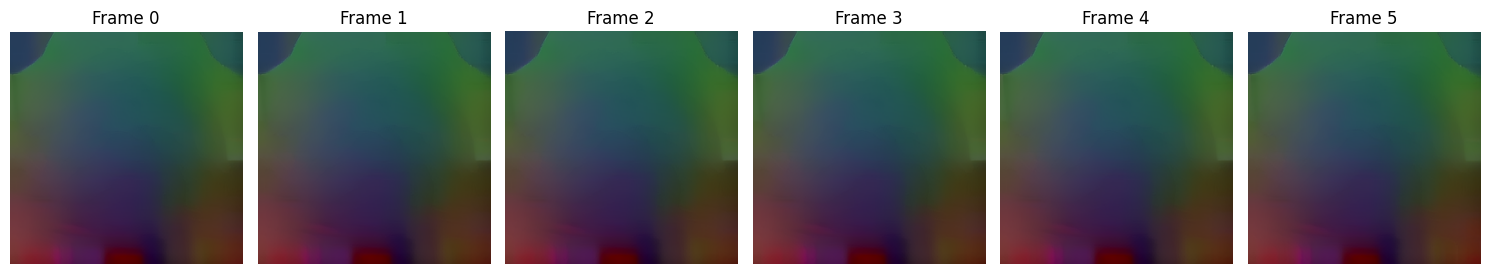

  0%|          | 6/13626 [01:00<37:46:55,  9.99s/it]

0.1207137331366539
torch.Size([1, 13, 16, 32, 32])
model_output tensor(-2.7586, device='cuda:0', grad_fn=<MinBackward1>) tensor(3.2337, device='cuda:0', grad_fn=<MaxBackward1>)
Ground Truth t=tensor([611], device='cuda:0'), step=0


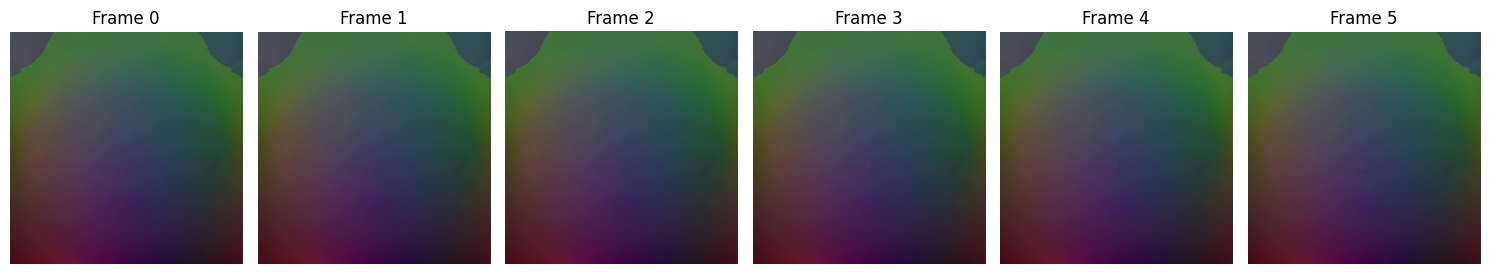

Model Pred t=tensor([611], device='cuda:0'), step=0


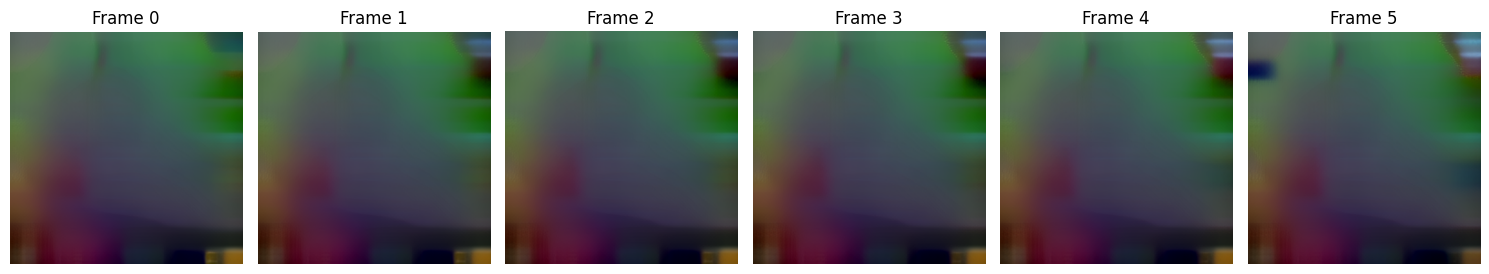

  0%|          | 7/13626 [01:10<37:37:38,  9.95s/it]

0.14454281330108643


  0%|          | 7/13626 [01:10<38:03:09, 10.06s/it]


KeyboardInterrupt: 

In [18]:
# weight_dtype=torch.float32
transformer = transformer.train().to("cuda")

for step in range(5):
    # for step in range(5):
    for idx, batch in enumerate(tqdm(data_loader)):
        # models_to_accumulate =  [transformer] !!!!!!!!!!!!!!
        # with accelerator.accumulate(models_to_accumulate): !!!!!!!!!!!!!!!
            latent_chunks = []
            ref_mask_chunks = []

            # Initialize necessary data for diffusion
            for i, video in enumerate(batch["video_chunks"]):
                video = video[:,:,:50,...].to(accelerator.device).to(weight_dtype)

                latent = encode_video(vae, video) # [B, F, C_z, H, W]
                # plot(latent)
                
                # Encode Video
                latent = encode_video(vae, video) # [B, F, C_z, H, W]
                latent_chunks.append(latent)

                # Ref Mask Chunk, Mask of shape [B, F, H, W, C]
                B, F_z, C, H, W = latent.shape
                rm = torch.zeros((B, F_z, 1, H, W), device=accelerator.device, dtype=weight_dtype)
                rm[:, 0] = 1.0
                ref_mask_chunks.append(rm)

            sequence_infos = [[False, torch.arange(chunk.shape[1])]for chunk in latent_chunks]
            
            # Sample Random Noise
            B, F_z, C_z, H_z, W_z = latent_chunks[0].shape
            timesteps = torch.randint(
                0,
                999,
                # scheduler.config.num_train_timesteps,
                (B,),
                device=accelerator.device
            ).long()

            noised_latents = []
            for idx, latent in enumerate(latent_chunks):
                noise = torch.randn_like(latent, device=accelerator.device, dtype=weight_dtype)
                noisy_latent = scheduler.add_noise(latent, noise, timesteps)
                # print(f"Noised Latent t={timesteps}, step={step}")
                # brown = decode_video(vae, noisy_latent)
                # plot_video(brown)
                noised_latents.append(noisy_latent)

            # Trivial Audio, Text, and Condition
            audio_embeds = torch.zeros((B, F_z, 768), dtype=weight_dtype, device=accelerator.device)
            text_embeds  = torch.zeros((B, 1,
                unwrap_model(transformer).config.attention_head_dim * unwrap_model(transformer).config.num_attention_heads
            ), dtype=weight_dtype, device=accelerator.device)
            B, F_z, C_z, H_z, W_z = noised_latents[0].shape
            zero_cond = [torch.zeros((B, F_z, 1, H_z, W_z), dtype=weight_dtype, device=accelerator.device)] * len(noised_latents)

            # Predict Noise
            print(noised_latents[0].shape)

            model_outputs = transformer(
                hidden_states=noised_latents,
                encoder_hidden_states=text_embeds,
                audio_embeds=audio_embeds,
                condition=zero_cond,
                timestep=timesteps,
                sequence_infos=sequence_infos,
                image_rotary_emb=None,
                return_dict=False
            )[0]

            model_output = torch.cat(model_outputs, dim=0)
            model_input = torch.cat(latent_chunks, dim=0)
            noisy_input = torch.cat(noised_latents, dim=0)

            print("model_output", model_output.min(), model_output.max())
            model_pred = scheduler.get_velocity(model_output, noisy_input, timesteps)

            alphas_cumprod = scheduler.alphas_cumprod[timesteps].to(weight_dtype)
            weights = 1 / (1 - alphas_cumprod)
            while len(weights.shape) < len(model_pred.shape):
                weights = weights.unsqueeze(-1)
            target = model_input
            loss = torch.mean((weights * (model_pred - target) ** 2).reshape(B, -1), dim=1)
            loss = loss.mean()
            accelerator.backward(loss)

            if step==0: recon = decode_video(vae, model_input)
            print(f"Ground Truth t={timesteps}, step={step}")
            plot_video(recon)
            print(f"Model Pred t={timesteps}, step={step}")
            drift = decode_video(vae, model_pred)
            plot_video(drift)
            print(loss.item())

            if i == 3: break

            

In [13]:
torch.cuda.empty_cache()